In [1]:
%matplotlib notebook

Code to re-create Figure 2 EF and Supplementary Figure 1 I & J

In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 20,
    'style'  : 'normal'}

matplotlib.rc('font', **font)
# The above is necessary to have all text in the saved svg as Arial text.
# Makes modification of figure in illustrator much easier.

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy import io as sio
import json
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

C:\Users\tadres\Miniconda3\envs\depol_block_publication\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_path = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\all_data\\ephys')
#save_path = Path('G:\\My Drive\\PhD\\Papers\\Vanishing spikes\\plots\\Fig1\\ephys')
save_path = 'define save path' # and change SAVE_PLOT in shared_functions.py
odor_sim_2D_path = Path('G:\\Shared drives\\LouisLab COLLABORATIVE Vanishing Spikes\\Simulations\\Odor Simulations (Rectangular Arena)\\Simulation\\Odor Profile\\60s')

In [4]:
# ODOR TO LIQUID CONVERSION RATE
# Philips simulation is showing odor in air.
# to be consistent it would be best to show the liquid converted odor!
# Detailed calculation in 'prepare_trajectory_odor_stimulus.ipynb' notebook
LIQUID_TO_AIR = 3.3897863527842462

In [5]:
def plot_PSTH(data, odor_conc, savename, ylim, aq_rate=10000,
             xlim=None, sensory_experience=False):
    
    lw_odor = 1
    lw_PSTH = 0.1

    odor = data['pressure [mbar]']/200 * odor_conc
 
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax1.plot(data['Time [s]'], odor, c='gold', lw=lw_odor)
    #ax1_right = ax1.twinx()
    #ax1_right.plot(data['Time [s]'], light, c='red', lw=lw)
    
    if sensory_experience:
        integration_time = 10000 # 1 second
        odor_stim = data['pressure [mbar]']/200 * odor_conc


        # for performance reasons we can't apply the 1/c*dc/dt calculation to every point.
        # Instead take the frequency of odor stimulus (50 Hz) and only consider points every 20 ms
        take_every = int(round((1/50) / data['Time [s]'][1]))

        # I probably don't have to filter here as the stimulus is already filtered during creation
        sensory_exp = np.zeros((data.shape[0]))
        sensory_exp.fill(np.nan)

        for i_inner in np.arange(integration_time, sensory_exp.shape[0]-1, take_every):
            #print(i_inner)
            sensory_exp[i_inner] = (1/odor_stim.iloc[i_inner]) * \
                ((odor_stim.iloc[i_inner] - odor_stim.iloc[i_inner-integration_time]) / integration_time)

        # Due to integration over time everything is shifted by integration time
        # roll array by integration time - since we cut of end and beginning that shouldn't be a problem
        sensory_exp_correct = np.roll(sensory_exp, integration_time)
        
        time_dC = np.linspace(0, data.loc[data.shape[0] - 1, 'Time [s]'], 
                                 sensory_exp[~np.isnan(sensory_exp)].shape[0])
        
        ax1_right = ax1.twinx()
        ax1_right.plot(time_dC,
                       sensory_exp_correct[~np.isnan(sensory_exp_correct)],
                       c='r', lw=lw_odor)
        ax1_right.set_ylabel('1/c*dc/dt, dt=' + repr(integration_time/aq_rate))

    ax1.set_ylabel('EtB [uM]')
    #ax1_right.set_ylabel('uW/mm2')
    
        
    ax2 = fig.add_subplot(312, sharex=ax1)
    ax2.set_rasterization_zorder(1)
    position = 0
    for counter, trial in enumerate(data.columns):
        if 'spikes_' in trial:
            ax2.eventplot(np.where(data[trial] == 1)[0] / aq_rate,
                         linewidth=0.05, lineoffsets=position, color='k',zorder=0)
            position += 1

    ax3 = fig.add_subplot(313, sharex=ax1)        

    ax3.plot(data['Time [s]'], data['PSTH [Hz]'], c='k', lw=lw_PSTH)
    ax3.plot(data['Time [s]'], data['PSTH [Hz]'] - data['PSTH SEM'], c='k', alpha=0.5, lw=lw_PSTH)
    ax3.plot(data['Time [s]'], data['PSTH [Hz]'] + data['PSTH SEM'], c='k', alpha=0.5, lw=lw_PSTH)
    ax3.set_ylim(ylim)

    ax3.set_ylabel('Firing rate [Hz]')
    
    if xlim is not None:
        ax1.set_xlim(xlim)

            
    ax3.set_xlabel('Time[s]')
    #fig.savefig(Path(save_path, savename), rasterized=True, dpi=300) # Uncomment to save plots

In [6]:
def collect_data_plot_trajectory(path_trajectoy,
                                 stimulation_path,
                                start_time,
                                end_time,
                                savename,
                                xlim,
                                ylim, 
                                show_odor_sim=False,
                                odor_sim_file_name=None,
                                vmin=0,
                                vmax=30):
    
    for current_file in path_trajectoy.iterdir():
        if 'csv' in current_file.name:
            data = pd.read_csv(current_file)
    animal_coordinates = pd.read_csv(Path(stimulation_path, 'filtered_poly4_animal_coordinates.csv'))
    
    if show_odor_sim:
        odor_simulation = sio.loadmat(Path(stimulation_path, 'SensoryExperience_poly4.mat'))
        odor_sim_2D = sio.loadmat(Path(odor_sim_2D_path, odor_sim_file_name))

    with open((Path(stimulation_path, 'experiment_settings.json')), 'r') as file:
        experiment_settings = json.load(file)
        PiVR_recording_freq = experiment_settings['Framerate']
        px_per_mm = experiment_settings['Pixel per mm']
        source_y, source_x = experiment_settings['Source y'], experiment_settings['Source x']
    
    if show_odor_sim:
        starttime_index = np.searchsorted(odor_simulation['t'][0], start_time)
        endtime_index = np.searchsorted(odor_simulation['t'][0], end_time)
    else:
        starttime_index = np.searchsorted(animal_coordinates['Time'], start_time)
        endtime_index = np.searchsorted(animal_coordinates['Time'], end_time)

    ####################
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    if show_odor_sim:
        _for_cbar = ax.imshow(odor_sim_2D['output']*LIQUID_TO_AIR, cmap='afmhot',
                             vmin=vmin, vmax=vmax)
        # Not sure where this bug is coming from but somehow x and y seem flipped
        # take the sensory exp * 100 to fit it on the simulation! 
        #x_corrected = odor_sim_2D['output'].shape[1] - odor_simulation['x']*100
        #y_corrected = odor_sim_2D['output'].shape[0] - odor_simulation['y']*100
        x_corrected = odor_simulation['y']*100
        y_corrected = odor_simulation['x']*100
        
        ax.plot(y_corrected, x_corrected, c='k', alpha=.2)
         
        ax.plot(y_corrected[starttime_index:endtime_index], 
                x_corrected[starttime_index:endtime_index], c='magenta')
        
    else:
        ax.plot(animal_coordinates['Y-Head'],
                animal_coordinates['X-Head'], c='k',alpha=0.1)
        ax.plot(animal_coordinates['Y-Head'][starttime_index:endtime_index],
                animal_coordinates['X-Head'][starttime_index:endtime_index], c='magenta')

        # Add indication of center
        diameter_of_reinforcement_ring = 6.35 # 1/4 inch according to manufacturer
        radius_of_reinforcement_ring = diameter_of_reinforcement_ring/2
        circle1 = plt.Circle((source_y, source_x),
                             radius_of_reinforcement_ring * px_per_mm,
                             color='gold', alpha = 1, zorder=0)
        ax.add_patch(circle1)

    ax.axis('off')
    if show_odor_sim:
        scalebar = AnchoredSizeBar(ax.transData,
                           100, '10 mm', 'lower right',
                           pad=0.1,
                           color='k',
                           frameon=False,
                           size_vertical=0.01,
                           fontproperties=fontprops)
        
         # add colormap to explain the heatmap, control how many ticks using the ticks parameter
        cbar=fig.colorbar(_for_cbar, 
                          #ticks=[np.amin(real_odor_gradient),
                          #       np.amax(real_odor_gradient)], 
                          #cax=cax,
                          fraction=0.046, 
                          pad=0.04)
        # change fontsize, to see all parameters that can be changed: print(mpl.rcParams)
        #mpl.rcParams['font.size'] = 
        #cbar.set_label('IAA concentration [' r'$\mu$' + 'M]', fontsize = 20) # todo - check if really really mM???????????????????????
        cbar.set_label('EtB concentration [uM]', fontsize = 20)
        
    else:
        scalebar = AnchoredSizeBar(ax.transData,
                                   px_per_mm * 10, '10 mm', 'lower right',
                                   pad=0.1,
                                   color='k',
                                   frameon=False,
                                   size_vertical=0.01,
                                   fontproperties=fontprops)

    ax.add_artist(scalebar)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if show_odor_sim:
        #ax.invert_yaxis()
        #ax.invert_xaxis()
        pass

    #fig.savefig(Path(save_path, savename)) # uncomment to save
    
    return(data)

# Trajectory animal with 1:150 EtB source

In [10]:
path_50mM_trajectory1 = Path(root_path, 'Or42bSF EtB\\trajectories\\50mM_trajectory')

# This of course depends on the stimulus file!
start_time = 100
end_time = 190

cut_start_50mM = 15 # seconds
cut_end_50mM = 10 # seconds

# No need to change anything down here

corrected_start_time = start_time + cut_end_50mM
corrected_end_time = end_time - cut_end_50mM

total_time = end_time - start_time
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\50mM_trajectory\\2021.09.06_17-18-28_MS92xMS133_EtB50mM')

data_50mM_trajectory1 = collect_data_plot_trajectory(
    path_trajectoy = path_50mM_trajectory1,
    stimulation_path = stimulation_path,
    start_time = corrected_start_time,
    end_time = corrected_end_time,
    savename = '50mM_trajectory_plot_w_sim.svg',
    xlim= (200,650),#(300, 700),
    ylim= (400,850),#(450, 850),
    show_odor_sim=True,
    odor_sim_file_name='OdorProfile_EtB50mM.mat'
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


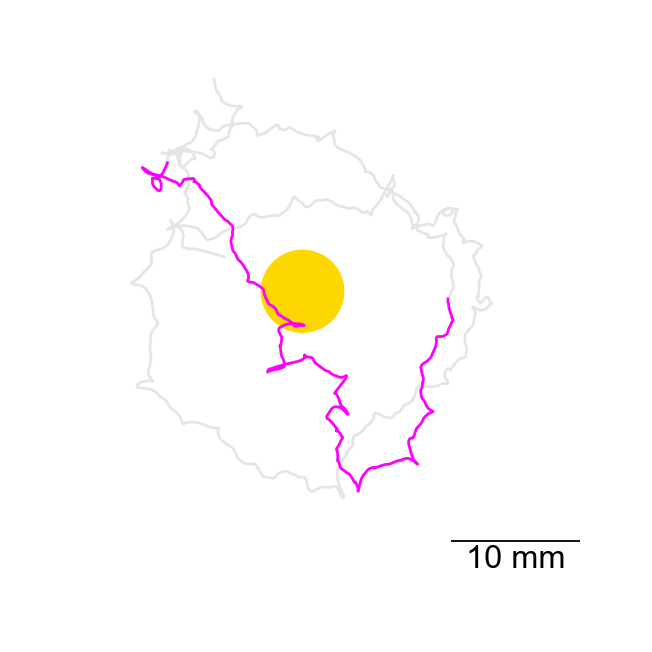

In [11]:
path_50mM_trajectory1 = Path(root_path, 'Or42bSF EtB\\trajectories\\50mM_trajectory')

# This of course depends on the stimulus file!
start_time = 100
end_time = 190

cut_start = 15 # seconds
cut_end = 10 # seconds

# No need to change anything down here

start_time = start_time + cut_end
end_time = end_time - cut_end

total_time = end_time - start_time
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\50mM_trajectory\\2021.09.06_17-18-28_MS92xMS133_EtB50mM')

data_50mM_trajectory1 = collect_data_plot_trajectory(
    path_trajectoy = path_50mM_trajectory1,
    stimulation_path = stimulation_path,
    start_time = start_time,
    end_time = end_time,
    savename = 'Fig2F_50mM_trajectory_plot.svg',
    xlim= (300, 700),
    ylim= (450, 850),
    show_odor_sim=False,
    odor_sim_file_name='OdorProfile_EtB50mM.mat'
)

<IPython.core.display.Javascript object>


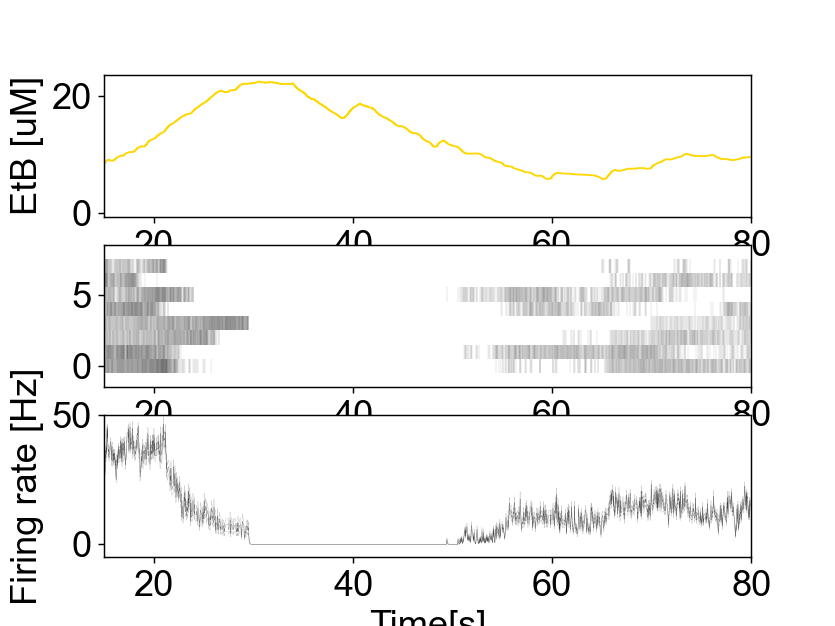

In [12]:
xlim_start = cut_start_50mM
xlim_end = int(round(data_50mM_trajectory1.loc[data_50mM_trajectory1.shape[0]-1,'Time [s]'] - cut_end_50mM))

plot_PSTH(data_50mM_trajectory1, odor_conc=25, savename='Fig2F_50mM_trajectory_PSTH.svg', 
          ylim=(-5,50),
          xlim=(xlim_start,xlim_end),
          sensory_experience=False)


# Trajectory 1 of EtB 1:7,500 odor source

<IPython.core.display.Javascript object>


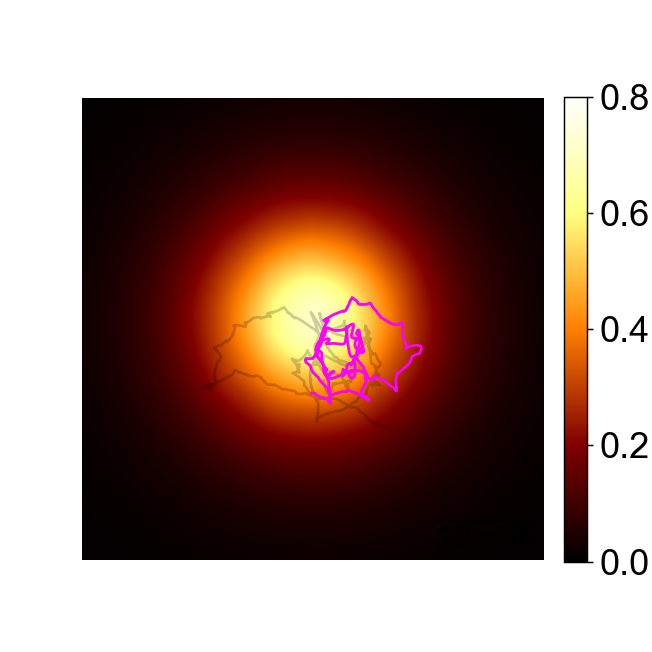

In [13]:
path_1mM_trajectory1 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory1')

# This of course depends on the stimulus file!
start_time = 30
end_time = 130

cut_start_1mM = 10 # seconds
cut_end_1mM = 30 # seconds

# No need to change anything down here

corrected_start_time = start_time + cut_end
corrected_end_time = end_time - cut_end
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory1\\2021.09.03_16-32-28_MS92xMS133_EtB1mM')

data_1mM_trajectory1 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory1,
    stimulation_path = stimulation_path,
    start_time = corrected_start_time,
    end_time = corrected_end_time,
    savename = '1mM_trajectory1_plot_w_sim.svg',
    xlim= (200,650),#(300, 700),
    ylim= (400,850),#(450, 850),
    show_odor_sim=True,
    odor_sim_file_name='OdorProfile_EtB1mM.mat',
    vmin=0,
    vmax=0.8
)

In [14]:
path_1mM_trajectory1 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory1')

# This of course depends on the stimulus file!
start_time = 30
end_time = 130

cut_start = 10 # seconds
cut_end = 20 # seconds

# No need to change anything down here

start_time_1mM1 = start_time + cut_end
end_time_1mM1 = end_time - cut_end
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory1\\2021.09.03_16-32-28_MS92xMS133_EtB1mM')

data_1mM_trajectory1 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory1,
    stimulation_path = stimulation_path,
    start_time = start_time_1mM1,
    end_time = end_time_1mM1,
    savename = 'Fig2E_1mM_trajectory1_plot.svg',
    xlim=(400, 630),
    ylim=(500, 730))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


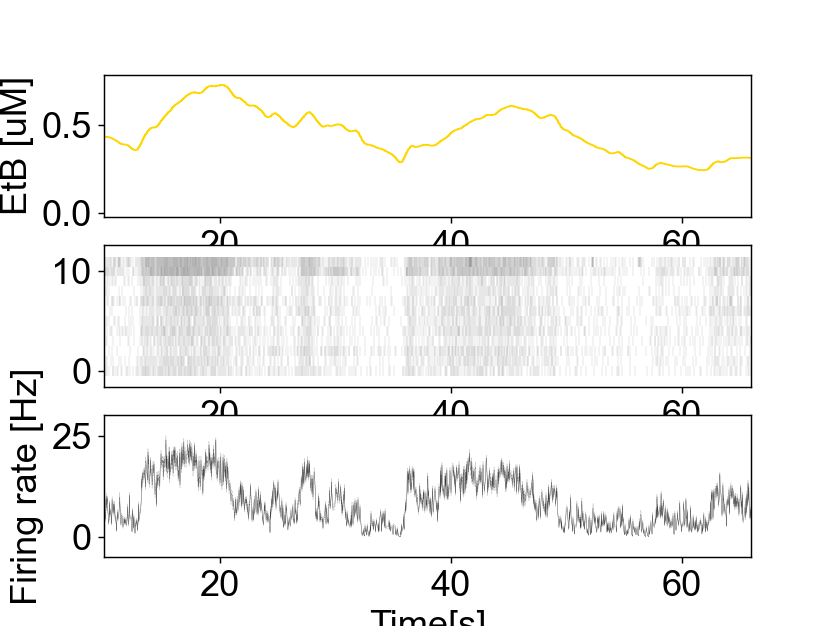

In [15]:
xlim_start = cut_start_1mM
xlim_end = int(round(data_1mM_trajectory1.loc[data_1mM_trajectory1.shape[0]-1,'Time [s]'] - cut_end_1mM))

plot_PSTH(data_1mM_trajectory1, odor_conc=1, savename='Fig2E_1mM_trajectory1_PSTH.svg', 
          ylim=(-5,30),
          xlim=(xlim_start,xlim_end),
          sensory_experience=False)


# Trajectory 3 of EtB 1:7,500 odor source

<IPython.core.display.Javascript object>


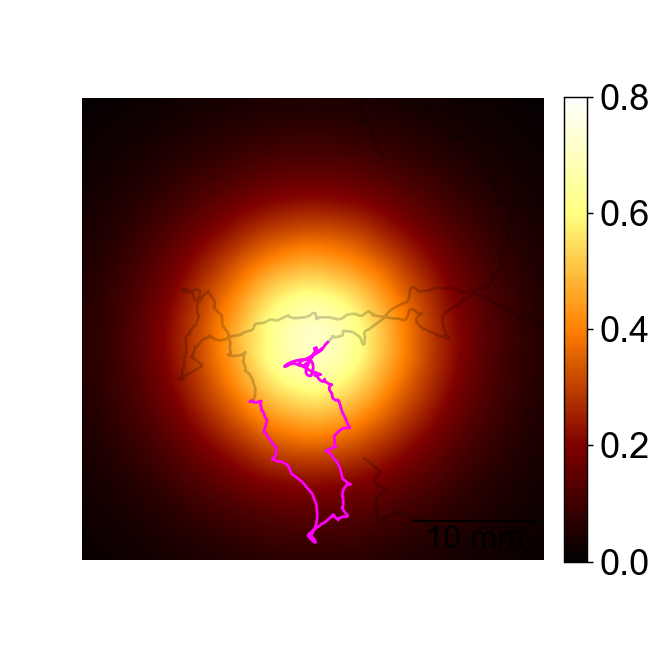

In [17]:
path_1mM_trajectory3 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory3')

start_time = 50
end_time = 140

cut_start_1mM3 = 10 # seconds
cut_end_1mM3 = 25 # seconds

# No need to change anything down here

start_time_corrected = start_time + cut_start_1mM3
end_time_corrected = end_time - cut_end_1mM3
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory3\\2021.09.03_16-38-51_MS92xMS133_EtB1mM')

data_1mM_trajectory3 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory3,
    stimulation_path = stimulation_path,
    start_time = start_time_corrected,
    end_time = end_time_corrected,
    savename = '1mM_trajectory_plot3_w_sim.svg',
    xlim=(240, 610),
    ylim=(460, 830),
    show_odor_sim=True,
    odor_sim_file_name='OdorProfile_EtB1mM.mat',
    vmin=0,
    vmax=0.8)

<IPython.core.display.Javascript object>


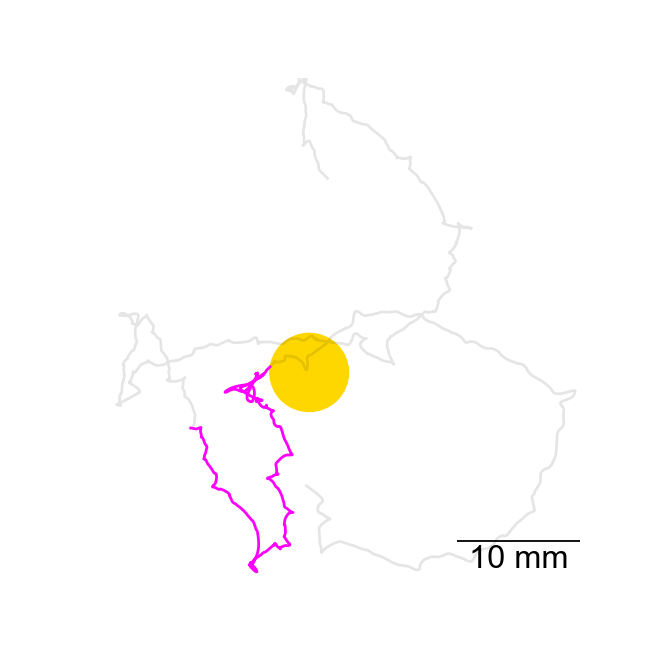

In [18]:
path_1mM_trajectory3 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory3')

start_time = 50
end_time = 140

cut_start_1mM3 = 10 # seconds
cut_end_1mM3 = 25 # seconds

# No need to change anything down here

start_time_corrected = start_time + cut_start_1mM3
end_time_corrected = end_time - cut_end_1mM3
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory3\\2021.09.03_16-38-51_MS92xMS133_EtB1mM')

data_1mM_trajectory3 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory3,
    stimulation_path = stimulation_path,
    start_time = start_time_corrected,
    end_time = end_time_corrected,
    savename = 'SIFig1I_1mM_trajectory_plot3.svg',
    xlim=(390, 770),
    ylim=(500, 880))

<IPython.core.display.Javascript object>


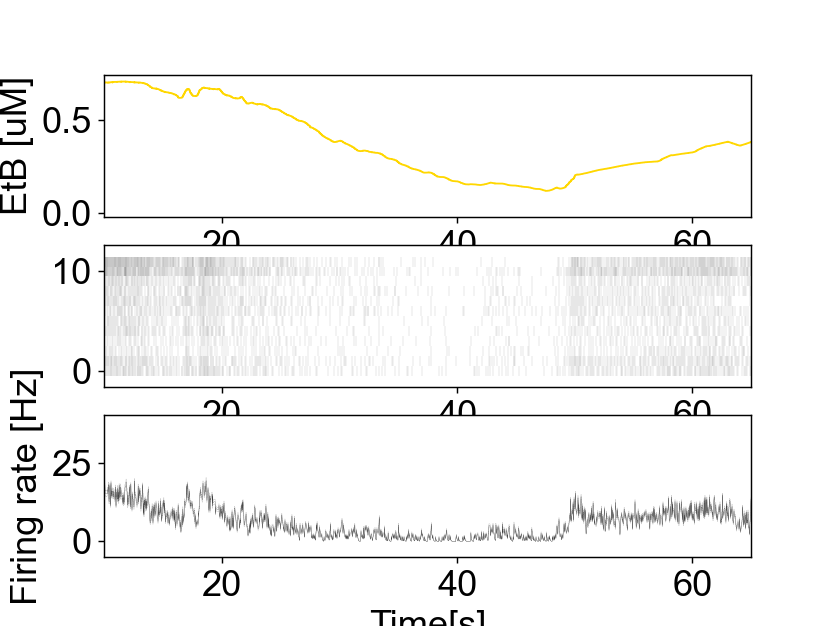

In [19]:
xlim_start = cut_start_1mM3
xlim_end = int(round(data_1mM_trajectory3.loc[data_1mM_trajectory3.shape[0]-1,'Time [s]'] - cut_end_1mM3))

plot_PSTH(data_1mM_trajectory3, odor_conc=1, 
          savename='SIFig1I_1mM_trajectory3_PSTH.svg', 
          ylim=(-5,40),
          xlim=(xlim_start,xlim_end),
         sensory_experience=False)

# Trajectory 4 of EtB 1:7,500 odor source

<IPython.core.display.Javascript object>


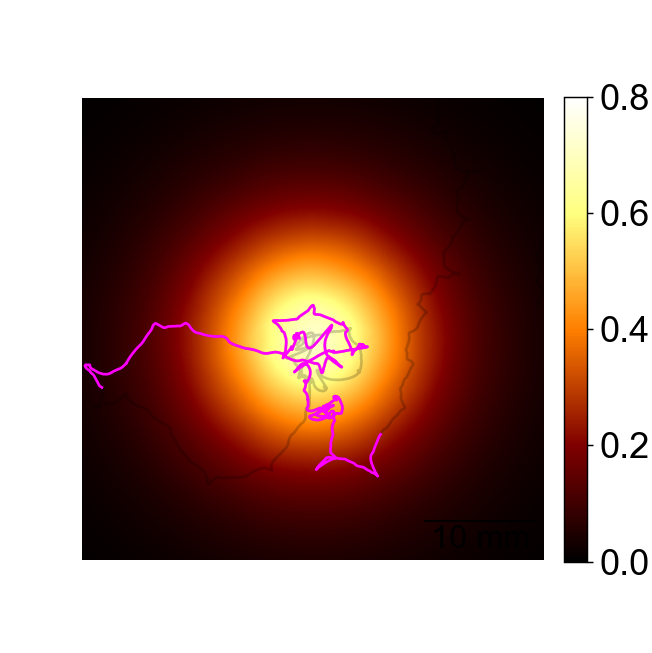

In [20]:
path_1mM_trajectory4 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory4')

start_time = 50
end_time = 140

cut_start_1mM4 = 10 # seconds
cut_end_1mM4 = 25 # seconds

# No need to change anything down here

start_time_corrected = start_time + cut_start_1mM4
end_time_corrected = end_time - cut_end_1mM4
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory4\\2021.09.04_16-40-10_MS92xMS133_EtB1mM')

data_1mM_trajectory4 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory4,
    stimulation_path = stimulation_path,
    start_time = start_time,
    end_time = end_time,
    savename = '1mM_trajectory4_w_sim.svg',
    xlim=(220, 630),
    ylim=(440, 850),
    show_odor_sim=True,
    odor_sim_file_name='OdorProfile_EtB1mM.mat',
    vmin=0,
    vmax=0.8)

<IPython.core.display.Javascript object>


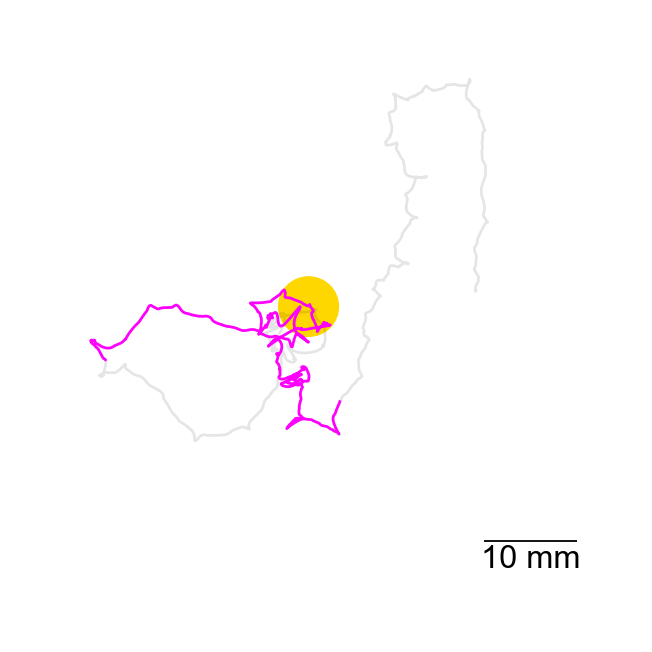

In [21]:
path_1mM_trajectory4 = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory4')

start_time = 50
end_time = 140

cut_start_1mM4 = 10 # seconds
cut_end_1mM4 = 25 # seconds

# No need to change anything down here

start_time_corrected = start_time + cut_start_1mM4
end_time_corrected = end_time - cut_end_1mM4
        
stimulation_path = Path(root_path, 'Or42bSF EtB\\trajectories\\1mM_trajectory4\\2021.09.04_16-40-10_MS92xMS133_EtB1mM')

data_1mM_trajectory4 = collect_data_plot_trajectory(
    path_trajectoy = path_1mM_trajectory4,
    stimulation_path = stimulation_path,
    start_time = start_time,
    end_time = end_time,
    savename = 'SIFig1J_1mM_trajectory_plot4.svg',
    xlim=(270, 770),
    ylim=(410, 910))

<IPython.core.display.Javascript object>


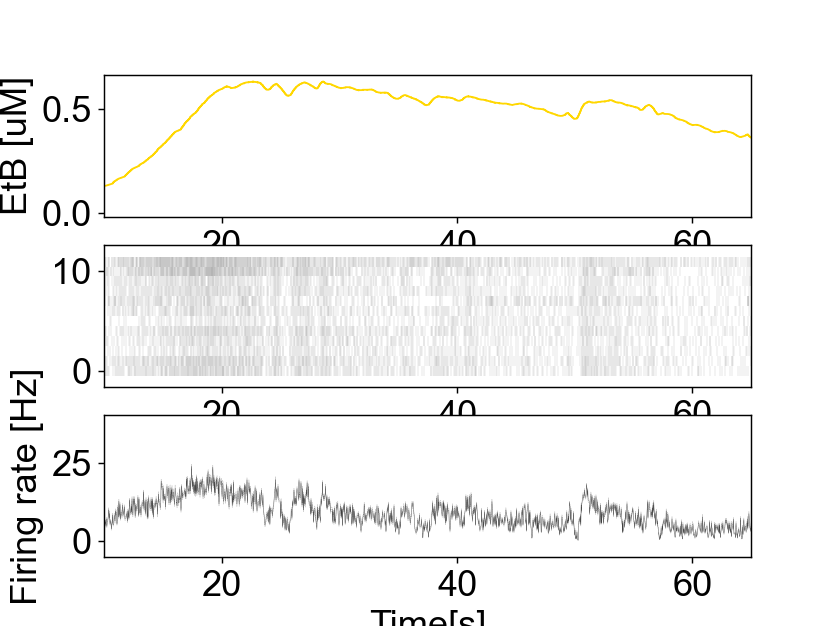

In [22]:
xlim_start = cut_start_1mM4
xlim_end = int(round(data_1mM_trajectory4.loc[data_1mM_trajectory4.shape[0]-1,'Time [s]'] - cut_end_1mM4))

plot_PSTH(data_1mM_trajectory4, odor_conc=1, 
          savename='SIFig1J_1mM_trajectory4_PSTH.svg', 
          ylim=(-5,40),
          xlim=(xlim_start,xlim_end),
          sensory_experience=False)